## AGAME Workflow

In [10]:
'''
This code includes all the steps needed to compute GPP maps with AGAME methodology:
The methodology includes the following steps:

1)Get icos tables (15 sites)
2)Get Sentinel-2 tables (15 sites)
3)Get ecosystem boundaries (15 sites)
4)Combine tables
5)Train XGBoost model
6)Evaluate XGBoost model
7)Create GPP maps (15 sites)
8)Creata uncertainty maps
'''

'\nThis code includes all the steps needed to compute GPP maps with AGAME methodology:\nThe methodology includes the following steps:\n\n1)Get icos tables (15 sites)\n2)Get Sentinel-2 tables (15 sites)\n3)Get ecosystem boundaries (15 sites)\n4)Combine tables\n5)Train XGBoost model\n6)Evaluate XGBoost model\n7)Create GPP maps (15 sites)\n8)Creata uncertainty maps\n'

In [11]:
import deims
import pandas as pd
import geopandas as gpd
import folium
import ee
import xarray
import geemap
import rioxarray
from pyproj import CRS
from xgboost import XGBRegressor
import os

In [12]:
def get_coordinates_area(site_list, site):
    df = pd.read_excel(site_list)
    site_url = df['deims'].loc[df['station id'] == site].values[0]
    if pd.isna(site_url):
        raise ValueError("The site DEIMS url is empty. Please provide a valid site URL.")
    else:
        boundaries   = deims.getSiteBoundaries([site_url])
        information = deims.getSiteById(site_id=site_url)
    return df, boundaries, information

def map_coordinates_area(df, boundaries, site):
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:3857"
    )
    gdf = gdf.loc[gdf['station id'] == site]
    centroid = gdf.geometry.centroid.union_all()
    m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12)
    for idx, row in gdf.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=row['site name']
        ).add_to(m)

    folium.GeoJson(boundaries).add_to(m)

    return m

def get_gee_area(boundaries):
    total_bounds = boundaries.total_bounds
    aoi = ee.Geometry.Rectangle([total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3]])
    # Initialize the geemap Map
    Map = geemap.Map()

    # Add the rectangle to the map
    Map.addLayer(aoi, {}, 'Bounding Box')

    # Center the map around the bounding box
    Map.centerObject(aoi, 10)

    return Map, aoi

def apply_scale_factors_s2(image):
    optical_bands = image.select(['B.']).divide(10000)
    thermal_bands = image.select(['B.*']).divide(10000)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

def apply_scale_factors_e5(image):
    image = image.divide(24*60*60)
    return image

# function to derive VIs
def calculateVI(image):
    '''This method calculates different vegetation indices in a image collection and adds their values as new bands'''

    # defining dictionary of bands Sentinel-2 
    dict_bands = {

        "blue"  :  'B2',                              #Blue band                        
        "green" :  'B3',                              #Green band
        "red"   :  'B4',                              #Red band
        "red1"  :  'B5',                              #Red-edge spectral band   
        "red2"  :  'B6',                              #Red-edge spectral band
        "red3"  :  'B7',                              #Red-edge spectral band    
        "NIR"   :  'B8',                              #Near-infrared band
        "NIRn"  :  'B8A',                             #Near-infrared narrow
        "WV"    :  'B9',                              #Water vapour
        "SWIR1" :  'B11',                             #Short wave infrared 1
        "SWIR2" :  'B12',                             #Short wave infrared 2
    }

    # specify bands 
    dict  = dict_bands
    blue  = dict["blue"]                              #Blue band                        
    green = dict["green"]                             #Green band
    red   = dict["red"]                               #Red band
    red1  = dict["red1"]                              #Red-edge spectral band    
    red2  = dict["red2"]                              #Red-edge spectral band
    red3  = dict["red3"]                              #Red-edge spectral band
    NIR   = dict["NIR"]                               #Near-infrared band
    NIRn  = dict["NIRn"]                              #Near-infrared band
    WV    = dict["WV"]                                #Water vapour
    SWIR1 = dict["SWIR1"]                             #Short wave infrared 1
    SWIR2 = dict["SWIR2"]                             #Short wave infrared 2

    bands_for_expressions = {

        'blue'  : image.select(blue).divide(10000),
        'green' : image.select(green).divide(10000), 
        'red'   : image.select(red).divide(10000),
        'red1'  : image.select(red1).divide(10000), 
        'red2'  : image.select(red2).divide(10000),
        'red3'  : image.select(red3).divide(10000), 
        'NIR'   : image.select(NIR).divide(10000),
        'NIRn'  : image.select(NIRn).divide(10000),
        'WV'    : image.select(WV).divide(10000),
        'SWIR1' : image.select(SWIR1).divide(10000),
        'SWIR2' : image.select(SWIR2).divide(10000)}

    # greeness related indices
    # NDVI                                                                             (Rouse et al., 1974)
    NDVI  = image.normalizedDifference([NIR, red]).rename("NDVI") 
    # EVI                                                                             
    EVI   = image.expression('2.5*(( NIR - red ) / ( NIR + 6 * red - 7.5 * blue + 1 ))', 
            bands_for_expressions).rename("EVI")
    # EVI2                                                                             (Jiang et al., 2008)
    EVI2  = image.expression('2.5*(( NIR - red ) / ( NIR + 2.4 * red + 1 ))', 
            bands_for_expressions).rename("EVI2")

    # greeness related indices with Sentinel-2 narrow bands / Red-edge
    # Clr
    CLr  = image.expression('(red3/red1)-1', bands_for_expressions).rename("CLr")
    # Clg
    Clg  = image.expression('(red3/green)-1', bands_for_expressions).rename("CLg")
    # MTCI
    MTCI = image.expression('(red2-red1)/(red1-red)', bands_for_expressions).rename("MTCI")
    # MNDVI                                                                            (Add reference)
    MNDVI = image.normalizedDifference([red3, red1]).rename("MNDVI")    

    # water related indices
    # MNDWI                                                                            (Add reference)
    MNDWI = image.normalizedDifference([green, SWIR1]).rename("MNDWI")    
    # NDWI OR LSWI or NDII or NDMI                                                     (Add reference)
    LSWI  = image.normalizedDifference([NIR, SWIR1]).rename("LSWI")
    # NDII                                                                             (Hunt & Qu, 2013)
    NDII   = image.normalizedDifference([NIR, SWIR2]).rename("NDII")

    image = image.addBands(NDVI).addBands(EVI).addBands(EVI2)
    image = image.addBands(CLr).addBands(Clg).addBands(MTCI).addBands(MNDVI)
    image = image.addBands(MNDWI).addBands(LSWI).addBands(NDII)

    return image 

def get_s2_array(period,aoi,sentinel_bands,cloud_percentage=100,resolution=100):
    ic = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(period[0],period[1])
    ic = ic.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',cloud_percentage))
    ic = ic.filterBounds(aoi) 
    ic = ic.map(apply_scale_factors_s2)
    ic = ic.map(calculateVI)
    ic = ic.select(sentinel_bands)
    ic_sample = ic.getRegion(aoi, resolution).getInfo()
    return ic_sample, ic

def get_s2_df(s2_array):
    df = pd.DataFrame(s2_array[1:], columns=s2_array[0])
    df = df.iloc[:,1:]
    df['time'] = pd.to_datetime(df['time'], unit='ms').dt.date
    df['time'] = pd.to_datetime(df['time'])
    df.set_index(['time','latitude','longitude'], inplace=True)
    return df

def get_e5_array(period,aoi,e5_bands,resolution=100):
    e5 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR').filterDate(period[0],period[1])
    e5 = e5.filterBounds(aoi).select(e5_bands)
    e5 = e5.map(apply_scale_factors_e5)
    e5_sample = e5.getRegion(aoi, resolution).getInfo()
    return e5_sample, e5

def get_e5_df(e5_array):
    dfe5 = pd.DataFrame(e5_array[1:], columns=e5_array[0])
    dfe5['time'] = pd.to_datetime(dfe5['id'], format='%Y%m%d')
    dfe5 = dfe5.iloc[:,1:]
    dfe5.set_index(['time','latitude','longitude'], inplace=True)
    dfe5.rename(columns={'surface_net_solar_radiation_sum':'SW_IN_ERA_GEE'}, inplace=True)
    return dfe5

def merge_s2_e5(s2_df, e5_df):
    df1 = s2_df.reset_index()
    df2 = e5_df.reset_index()
    df_merged = df1.merge(df2, on=['time', 'latitude', 'longitude'], how='left')

    df_merged = df_merged.dropna()
    df_merged.set_index(['time','latitude','longitude'], inplace=True)
    return df_merged

def map_collection(ic, band, label):
    # Define visualization parameters
    vis_params = {
        'min': 0,
        'max': 0.1,
        'palette': ['blue', 'white', 'green']
    }

    # Create a map
    Map = geemap.Map()

    # Center the map on the area of interest
    Map.centerObject(aoi, 12)

    # Add the mean NDVI layer to the map
    Map.addLayer(ic.select(band).first().clip(aoi), vis_params, label)

    # Display the map
    return Map

def get_environmental_data(directory_data, filename,sentinel_vi,sentinel_bands, general):
    data = pd.read_csv(os.path.join(directory_data, filename), index_col='TIMESTAMP', parse_dates=['TIMESTAMP'])

    s2_all = data.columns.values.tolist()
    s2_all = sorted([item for item in s2_all if not (item.endswith('_residual') or 
                                                    item.endswith('_trend') or 
                                                    item.endswith('_season'))])

    s2_all = sorted([item for item in s2_all if not (item.startswith('CO2') or 
                                                    item.startswith('H_') or 
                                                    item.startswith('LE_'))])

    s2_all = [item for item in s2_all if item not in sentinel_vi]
    s2_all = [item for item in s2_all if item not in sentinel_bands]
    s2_all = [item for item in s2_all if item not in general]

    selected_columns = s2_all 
    data = data[selected_columns]
    return data

In [14]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
model_file = r"D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Model\xgboost_model_all_nogeneral.json"
site_list = r'D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Input\list_sites_icos.xlsx'
netcdf_output_gpp = r'D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Maps\GPP.nc'
geotif_output_gpp = r"D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Maps\GPP.tif"
netcdf_output_sw = r'D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Maps\SW.nc'
geotif_output_sw = r"D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Maps\SW.tif"
directory_data = r'D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Tables'
filename = 'Hohes Holz_preprocessed_01012019_26092023.csv'

sites_available = ['DE-HoH','IT-Tor','FI-Hyy','SE-Svb']
sentinel_vi = ['CLr','EVI','EVI2','LSWI', 'MNDVI','MNDWI','NDII','NDVI']
sentinel_bands  = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
general = ['latitude', 'longitude', 'elevation', 'canopy_height', 'biom_croplands', 'biom_dbf', 'biom_enf', 'biom_grasslands', 'winter','spring', 'summer', 'fall']
e5_bands = ['surface_net_solar_radiation_sum']
period = ['2023-06-01', '2023-06-30']
site = 'DE-HoH'

df, boundaries, information = get_coordinates_area(site_list, site)
# m = map_coordinates_area(df, boundaries, site)
Map, aoi = get_gee_area(boundaries)
s2_array, s2 = get_s2_array(period,aoi,sentinel_vi)
s2_df = get_s2_df(s2_array)
e5_array, e5 = get_e5_array(period,aoi,e5_bands)
e5_df = get_e5_df(e5_array)
# df_merged = merge_s2_e5(s2_df, e5_df)
Map = map_collection(s2, 'NDVI', 'NDVI Band')

data = get_environmental_data(directory_data, filename,sentinel_vi,sentinel_bands, general)

In [15]:
# data = pd.read_csv(os.path.join(directory_data, filename), index_col='TIMESTAMP', parse_dates=['TIMESTAMP'])

# s2_all = data.columns.values.tolist()
# s2_all = sorted([item for item in s2_all if not (item.endswith('_residual') or 
#                                                    item.endswith('_trend') or 
#                                                    item.endswith('_season'))])

# s2_all = sorted([item for item in s2_all if not (item.startswith('CO2') or 
#                                                    item.startswith('H_') or 
#                                                    item.startswith('LE_'))])

# s2_all = [item for item in s2_all if item not in sentinel_vi]
# s2_all = [item for item in s2_all if item not in sentinel_bands]
# s2_all = [item for item in s2_all if item not in general]

# selected_columns = s2_all 
# data = data[selected_columns]

s2_df = s2_df.reset_index()
data = data.reset_index()
data = data.rename(columns={'TIMESTAMP':'time'})

df_merged = s2_df.merge(data, on=['time'], how='left')
df_merged.set_index(['time','latitude','longitude'], inplace=True)

expected_columns = ['CLr', 'DAY_D', 'DAY_RANDUNC_N', 'EBC_CF_N', 'EVI', 'EVI2', 'G_F_MDS', 'LSWI', 'LW_IN_ERA', 'LW_IN_F', 'LW_IN_F_MDS', 'LW_IN_JSB', 'LW_IN_JSB_ERA', 'LW_IN_JSB_F', 'LW_OUT', 'MNDVI', 'MNDWI', 'NDII', 'NDVI', 'NETRAD', 'NIGHT_D', 'NIGHT_RANDUNC_N', 'PA_ERA', 'PA_F', 'PPFD_IN', 'PPFD_OUT', 'P_ERA', 'P_F', 'SWC_F_MDS_1', 'SWC_F_MDS_2', 'SW_IN_ERA', 'SW_IN_F', 'SW_IN_F_MDS', 'SW_IN_POT', 'SW_OUT', 'TA_ERA', 'TA_ERA_DAY', 'TA_ERA_DAY_SD', 'TA_ERA_NIGHT', 'TA_ERA_NIGHT_SD', 'TA_F', 'TA_F_DAY', 'TA_F_DAY_SD', 'TA_F_MDS', 'TA_F_MDS_DAY', 'TA_F_MDS_DAY_SD', 'TA_F_MDS_NIGHT', 'TA_F_MDS_NIGHT_SD', 'TA_F_NIGHT', 'TA_F_NIGHT_SD', 'TS_F_MDS_1', 'TS_F_MDS_2', 'TS_F_MDS_3', 'USTAR', 'VPD_ERA', 'VPD_F', 'VPD_F_MDS', 'WS_ERA', 'WS_F', 'day', 'month']
df_merged = df_merged[expected_columns]


In [16]:
loaded_model = XGBRegressor()
loaded_model.load_model(model_file)

y_pred = loaded_model.predict(df_merged)
df_merged['GPP'] = y_pred
ds = df_merged.to_xarray()

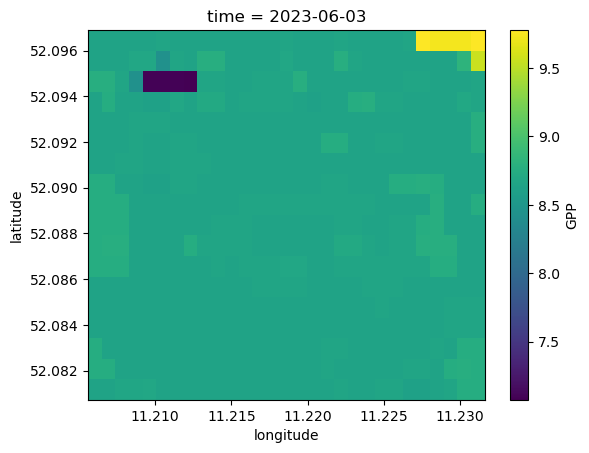

In [17]:
ds.GPP.isel(time=0).plot()
crs = CRS.from_epsg(4326) #3857

ds.attrs['crs'] = crs.to_string()
ds.GPP.to_netcdf(netcdf_output_gpp )

da = ds.GPP.isel(time=0)
da.rio.write_crs(crs.to_string(), inplace=True)
da.rio.to_raster(geotif_output_gpp)

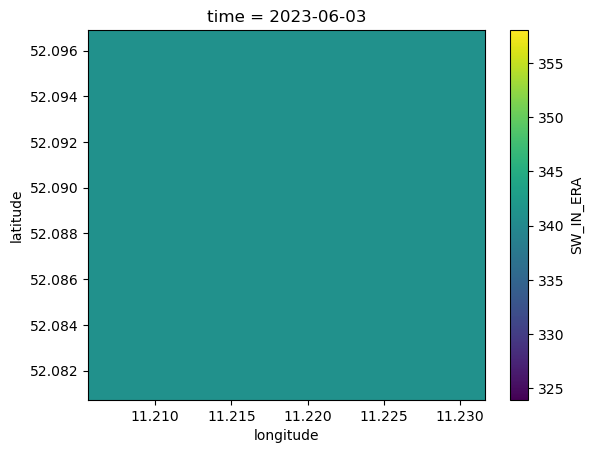

In [18]:
ds.SW_IN_ERA.isel(time=0).plot()
crs = CRS.from_epsg(4326) #3857

ds.attrs['crs'] = crs.to_string()
ds.SW_IN_ERA.to_netcdf(netcdf_output_sw)

da = ds.SW_IN_ERA.isel(time=0)
da.rio.write_crs(crs.to_string(), inplace=True)
da.rio.to_raster(geotif_output_sw)